In [1]:
import rafias_lib as rl
from astropy.io import fits
from astropy.table import Table, Column, hstack
from photutils import CircularAperture, CircularAnnulus, aperture_photometry
from astropy.modeling import models, fitting
import numpy as np
import pdb
import glob
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filenames_a1 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'+
                              '/NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T16h42m53/*.slp.fits')

In [3]:
filenames_b4 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'+
                              '/NRCN821WLP8SUB-*_489_SE_*/*.slp.fits')[:306]

In [4]:
centers_a1 = rl.gen_center_g2d(166, 160, 5, 400, 2, 2, 0, filenames_a1)

In [5]:
centers_b4 = rl.gen_center_g2d(162, 156, 5, 500, 2, 2, 0, filenames_b4)

In [6]:
rt_table = rl.radius_testing(centers_a1[0], 10, 110, 5, 20, 120, 5, 30, 130, 5, filenames_a1)

The minimum Standard deviation is -0.185554
It occurs for the radius r = 20.000000
It occurs for the inner radius r_in = 45.000000
It occurs for the outer radius r_out = 65.000000


In [7]:
rt_table.write('rt_320_for_jf.csv')

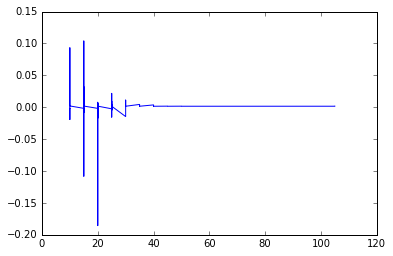

In [9]:
plt.plot(rt_table['r_source'], rt_table['norm_stdev'])

In [8]:
#a1 time series
a1_ts = rl.time_series(centers_a1[1], centers_a1[2], filenames_a1, 70, 72, 80)
a1_ts

raw_flux,bkg_flux,res_flux,time
float64,float64,float64,float64
3285047.08462,84373.0398256,3200674.04479,0.0
3289566.11335,86342.890025,3203223.22333,22.38012
3314176.50765,107908.84259,3206267.66506,44.76024
3289917.29943,85695.9675003,3204221.33193,67.14036
3288515.16357,86058.4272447,3202456.73632,89.52048
3287991.73399,85574.6065878,3202417.1274,111.9006
3303737.51825,101361.005526,3202376.51273,134.28072
3293751.13998,94200.8572436,3199550.28274,156.66084
3294934.21685,93509.0885304,3201425.12832,179.04096


In [9]:
#b4 time series
b4_ts = rl.time_series(centers_b4[1], centers_b4[2], filenames_b4, 70, 72, 80)
b4_ts

raw_flux,bkg_flux,res_flux,time
float64,float64,float64,float64
4257748.19289,140299.850789,4117448.34211,0.0
4271670.84016,154330.060321,4117340.77984,22.38012
4242031.167,127740.842038,4114290.32496,44.76024
4249686.61854,131017.930495,4118668.68805,67.14036
4255258.05795,129941.215295,4125316.84266,89.52048
4253160.27219,132424.479298,4120735.79289,111.9006
4239427.23183,122771.255484,4116655.97635,134.28072
4255701.10709,134297.772278,4121403.33481,156.66084
4236078.00239,119902.755147,4116175.24724,179.04096


In [10]:
a1_cen_pos = np.sqrt(np.square(centers_a1[1]) + np.square(centers_a1[2]))
b4_cen_pos = np.sqrt(np.square(centers_b4[1]) + np.square(centers_b4[2]))

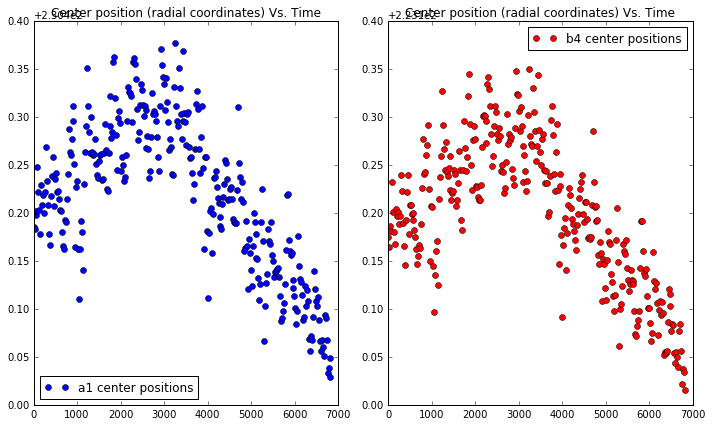

In [11]:
plt.figure(figsize = (10,6))
plt.subplot(1,2,1)
plt.plot(a1_ts['time'], a1_cen_pos, 'o', label = 'a1 center positions')
plt.legend(loc = 'best')
plt.title('Center position (radial coordinates) Vs. Time')
plt.subplot(1,2,2)
plt.plot(b4_ts['time'], b4_cen_pos, 'ro', label = 'b4 center positions')
plt.legend(loc = 'best')
plt.title('Center position (radial coordinates) Vs. Time')

plt.tight_layout()

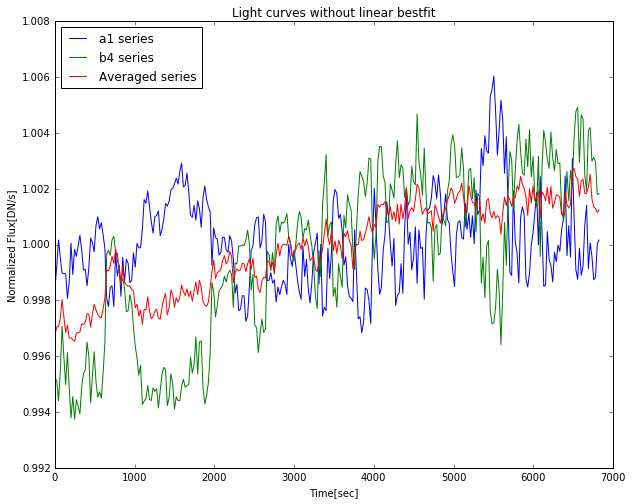

In [12]:
plt.figure(figsize = (10,8))
rl.light_curve(a1_ts['time'], a1_ts['res_flux'], style = 'b-', lbl = 'a1 series')
rl.light_curve(b4_ts['time'], b4_ts['res_flux'], style = 'g-', lbl = 'b4 series')
rl.light_curve(a1_ts['time'], (a1_ts['res_flux']+b4_ts['res_flux'])/2, style = 'r-', lbl = 'Averaged series')
plt.legend(loc = 'best')
plt.title('Light curves without linear bestfit')

In [13]:
detrended_a1 = rl.linear_bestfit(a1_ts['time'], a1_ts['res_flux'], 0.00002, 1)
detrended_b4 = rl.linear_bestfit(b4_ts['time'], b4_ts['res_flux'], 0.00002, 1)

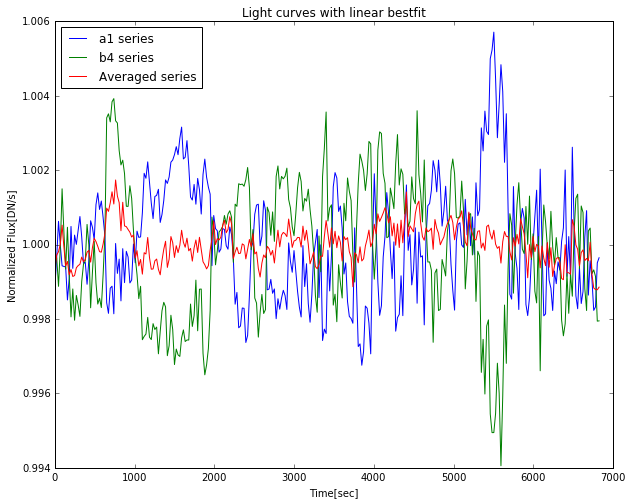

In [14]:
plt.figure(figsize = (10,8))
rl.light_curve(a1_ts['time'], detrended_a1, style = 'b-', lbl = 'a1 series')
rl.light_curve(b4_ts['time'], detrended_b4, style = 'g-', lbl = 'b4 series')
rl.light_curve(a1_ts['time'], (detrended_a1+detrended_b4)/2, style = 'r-', lbl = 'Averaged series')
plt.legend(loc = 'best')
plt.title('Light curves with linear bestfit')